In [89]:
import numpy as np
from matplotlib import pyplot as plt 
from pandas import read_csv
import sys
import os
from matplotlib import rcParams
import toml

# Rescaling plot

In [107]:
data_to_plot = []
os.chdir("./analysis/")
os.listdir("./")

['rescaling.py',
 'condensate.py',
 'data',
 'plots',
 'phi.pdf',
 'mass.py',
 'analysis.ipynb',
 '.ipynb_checkpoints',
 'plot.py']

Load data from selected folder

In [108]:
####################################################
folders = ["s_0.125_", "s_0.25_", "s_0.5_", "s_1.0_"] 
param_to_plot = "yukawa_coupling"
section_param_to_plot = "fermions"
####################################################


data = []

for folder in folders:
    
    os.chdir("data/" + folder)
    
    for config in sorted(os.listdir("./")):
        os.chdir(config)
        params = toml.load("input.toml")
        s = float(params['physics']['cutFraction'])
        plot_param = float(params[section_param_to_plot][param_to_plot])
        if plot_param == 0.0:
            plot_param = 1e-5
        csv_data = read_csv("traces.csv")
        phi = csv_data['phi'].to_numpy()
        #print(s, plot_param, np.average(phi))
        N = len(phi)
        data.append( (plot_param, s, np.average(phi), np.std(phi) / np.sqrt(N)) )
        os.chdir("../")
        os.listdir("./")

        data = sorted(data, key = lambda x: x[0])

    data_to_plot.append([data])
    os.chdir("../../")

Show plot

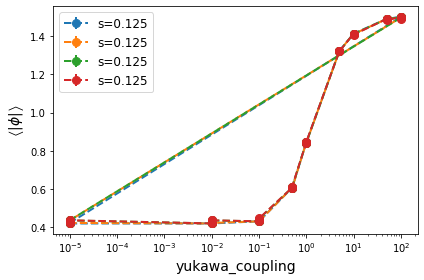

In [109]:
for data in data_to_plot:
    param = [d[0] for d in data[0]]
    s = data[0][0][1]
    val = [d[2] for d in data[0]]
    err = [d[3] for d in data[0]]   
    lab = "s=" + str(s)
    plt.errorbar(param, val, err, fmt='o--', label=lab, linewidth=2.0, markersize=8)

plt.xlabel(param_to_plot, fontsize=14)
plt.ylabel(r"$\left\langle |\phi| \right\rangle$", fontsize=14)
plt.xscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("phi.pdf")
plt.show()

# Mean Field equations of motion

In [ ]:
rcParams['text.usetex'] = True

####################################################
mypath = "./data/"
####################################################

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

sigma_vals = []
sigma_errs = []
tr_vals = []
tr_errs = []

pi_vals = [[] for _ in range(3)]
pi_errs = [[] for _ in range(3)]
trpi_vals = [[] for _ in range(3)]
trpi_errs = [[] for _ in range(3)]

s = []
for f in onlyfiles:
    cutoff_frac = float(f.split('_')[1])
    s.append(cutoff_frac)
print(s)
    
    
mypath = "./data/"
for cutoff_frac in sorted(s):
    filename = mypath + "traces_" + str(cutoff_frac) + "_.csv"
    
    print("\n Cutoff fraction:", cutoff_frac)
   
    data = read_csv(filename)
    #data = data.drop(labels=range(1,1000), axis=0)
    N = len(data['sigma'])

    # vals
    sigma_vals.append(np.average(data['sigma'].to_numpy()))
    pi_vals[0].append(np.average(data['pi1'].to_numpy()))
    pi_vals[1].append(np.average(data['pi2'].to_numpy()))
    pi_vals[2].append(np.average(data['pi3'].to_numpy()))
    tr_vals.append(np.average(data['tr'].to_numpy()))
    trpi_vals[0].append(np.average(data['trp1'].to_numpy()))
    trpi_vals[1].append(np.average(data['trp2'].to_numpy()))
    trpi_vals[2].append(np.average(data['trp3'].to_numpy()))
    
    print("sigma:", np.average(data['sigma'].to_numpy()))
    print("pions:", np.average(data['pi1'].to_numpy()), np.average(data['pi2'].to_numpy()), np.average(data['pi3'].to_numpy()))
    
    # errs
    sigma_errs.append(np.std(data['sigma'].to_numpy()) / np.sqrt(N-1))
    pi_errs[0].append(np.std(data['pi1'].to_numpy()) / np.sqrt(N-1))
    pi_errs[1].append(np.std(data['pi2'].to_numpy()) / np.sqrt(N-1))
    pi_errs[2].append(np.std(data['pi3'].to_numpy()) / np.sqrt(N-1))
    tr_errs.append(np.std(data['tr'].to_numpy()) / np.sqrt(N-1))
    trpi_errs[0].append(np.std(data['trp1'].to_numpy()) / np.sqrt(N-1))
    trpi_errs[1].append(np.std(data['trp2'].to_numpy()) / np.sqrt(N-1))
    trpi_errs[2].append(np.std(data['trp3'].to_numpy()) / np.sqrt(N-1))

    '''plt.plot(range(len(sigma_vals)), sigma_vals, label=r'$\sigma$')
    plt.xlabel("Langevin time", fontsize=22)
    plt.title(r"$s=\Lambda' / \Lambda$ = " + str(cutoff_frac), fontsize=22)
    plt.tight_layout()
    plt.savefig("plots/pi_evol/sigmaevol_" + str(cutoff_frac) + ".pdf")
    plt.close()

    plt.plot(range(len(pi_vals[0])), pi_vals[0], label=r'$\pi_1$')
    plt.plot(range(len(pi_vals[1])), pi_vals[1], label=r'$\pi_2$')
    plt.plot(range(len(pi_vals[2])), pi_vals[2], label=r'$\pi_3$')
    plt.xlabel("Langevin time", fontsize=22)
    plt.title(r"$s=\Lambda' / \Lambda$ = " + str(cutoff_frac), fontsize=22)
    plt.tight_layout()
    plt.savefig("plots/sigma_evol/pievol_" + str(cutoff_frac) + ".pdf")
    plt.close()

    pisq = [x*x + y*y + z*z for x, y, z in zip(data['pi1'], data['pi2'], data['pi3'])]
    plt.plot(range(len(pisq)), pisq)
    plt.xlabel("Langevin time", fontsize=22)
    plt.ylabel(r"$|\pi|^2$", fontsize=18)
    plt.title(r"$s=\Lambda' / \Lambda$ = " + str(cutoff_frac), fontsize=22)
    plt.tight_layout()
    plt.savefig("plots/pi2_evol/pi2_evol_" + str(cutoff_frac) + ".pdf")
    plt.close()'''

print(len(s), len(sigma_vals))



# Mass fit
### Fit exponential decay to get the mass

Load data

In [ ]:
from scipy.optimize import curve_fit as fit

####################################################
data_folder = ""
Nt = 
####################################################

def fitfuncSinh(x, m_re, A):
    return A * np.sinh(m_re*(Nt/2-x))

def fitToSinh(ydata, startidx, endidx, plot=False):
    yvals = ydata[startidx:endidx]
    xvals = np.array(range(startidx, endidx))

    fitparams = fit(fitfuncSinh, xvals, yvals, p0=[1e-2, np.log(1+mq0+yukawa_coupling*sigma)])
    #print("Mass: ", abs(fitparams[0][0]))
        
    return fitparams[0]
    
timeslices = data['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

corr = np.average(timeslices, axis=0)

fitparams = fitToSinh(corr, 1, Nt, plot)

plt.plot(range(1, Nt), corr[1:Nt], label="data")
xvals = np.linspace(0, Nt, 1000)
plt.plot(xvals, fitfuncSinh(xvals, fitparams[0], fitparams[1]), label='fit')
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

print("Params: ")
print("mq0:", mq0)
print("g:", yukawa_coupling)
print("Number of data points:", timeslices.shape[0])
print("Nt:", timeslices.shape[1])
print("Measured mass:", fitparams[0])

Sigma and condensate

In [ ]:
# Condensates plot
plt.errorbar(sorted(s), np.abs(sigma_vals), fmt='.-', yerr=sigma_errs, capsize=4, markersize=4, label=r'$\left\langle|\sigma|\right\rangle$')
plt.errorbar(sorted(s), np.abs(tr_vals), fmt='.-', yerr=tr_errs, capsize=4, markersize=4, label=r'$\left\langle|\bar\psi\psi|\right\rangle$')
plt.grid()
plt.legend(fontsize=18)
plt.xlabel(r"$s=\frac{\Lambda'}{\Lambda}$", fontsize=22)
plt.tight_layout()
#plt.ylim([0.78, 0.79])
plt.savefig("plots/condensates/sigma.pdf")
plt.close()


Compare each pion with corresponding condensate

In [ ]:
plt.errorbar(sorted(s), np.abs(pi_vals[0]), fmt='.-', yerr=pi_errs[0], capsize=4, markersize=12, label=r'$\left\langle|\pi_1|\right\rangle$')
plt.errorbar(sorted(s), np.abs(trpi_vals[0]), fmt='.-', yerr=trpi_errs[0], capsize=4, markersize=12, label=r'$\left\langle|\bar\psi\,\gamma_5\tau_1\,\psi|\right\rangle$')
plt.grid()
plt.legend(fontsize=18)
plt.xlabel(r"$s=\frac{\Lambda'}{\Lambda}$", fontsize=22)
plt.tight_layout()
plt.yscale('log')
#plt.ylim([0.0, 0.02])
plt.savefig("plots/condensates/pi1.pdf")
plt.close()

plt.errorbar(sorted(s), np.abs(pi_vals[1]), fmt='.-', yerr=pi_errs[1], capsize=4, markersize=12, label=r'$\left\langle|\pi_2|\right\rangle$')
plt.errorbar(sorted(s), np.abs(trpi_vals[1]), fmt='.-', yerr=trpi_errs[1], capsize=4, markersize=12, label=r'$\left\langle|\bar\psi\,\gamma_5\tau_2\,\psi|\right\rangle$')
plt.grid()
plt.legend(fontsize=18)
plt.xlabel(r"$s=\frac{\Lambda'}{\Lambda}$", fontsize=22)
plt.yscale('log')
plt.tight_layout()
#plt.ylim([0.577, 0.579])
plt.savefig("plots/condensates/pi2.pdf")
plt.close()

plt.errorbar(sorted(s), np.abs(pi_vals[2]), fmt='.-', yerr=pi_errs[2], capsize=4, markersize=12, label=r'$\left\langle|\pi_3|\right\rangle$')
plt.errorbar(sorted(s), np.abs(trpi_vals[2]), fmt='.-', yerr=trpi_errs[2], capsize=4, markersize=12, label=r'$\left\langle|\bar\psi\,\gamma_5\tau_3\,\psi\right\rangle$')
plt.grid()
plt.legend(fontsize=18)
plt.xlabel(r"$s=\frac{\Lambda'}{\Lambda}$", fontsize=22)
plt.yscale('log')
plt.tight_layout()
#plt.ylim([0.28, 0.283])
plt.savefig("plots/condensates/pi3.pdf")
plt.close()

Only pions

In [ ]:
plt.errorbar(sorted(s), np.abs(pi_vals[0]), fmt='.-', yerr=pi_errs[0], capsize=4, markersize=12, label=r'$\left\langle|\pi_1|\right\rangle$')
plt.errorbar(sorted(s), np.abs(pi_vals[1]), fmt='.-', yerr=pi_errs[1], capsize=4, markersize=12, label=r'$\left\langle|\pi_2|\right\rangle$')
plt.errorbar(sorted(s), np.abs(pi_vals[2]), fmt='.-', yerr=pi_errs[2], capsize=4, markersize=12, label=r'$\left\langle|\pi_3|\right\rangle$')
plt.grid()
plt.legend(fontsize=18)
plt.xlabel(r"$s=\frac{\Lambda'}{\Lambda}$", fontsize=22)
#plt.yscale('log')
plt.tight_layout()
#plt.ylim([0, 0.03])
plt.savefig("plots/pions.pdf")
plt.close()

Compute expected mass from background fields

In [ ]:
def expectedM(m0, g, sigma, pi):
    r2 = sigma**2 + pi[0]**2 + pi[1]**2 + pi[2]**2
    denom = 2*(g*sigma + m0 + 1)
    sqrroot = np.sqrt((g**2*r2 + 2*m0*(g*sigma + 1) + 2*g*sigma + m0**2 + 2)**2 - 4*(g*sigma+m0+1)**2)
    num = -sqrroot + g**2*r2 + 2*g*m0*sigma + 2*g*sigma + m0**2 + 2*m0 + 2
    return -np.log(num/denom)

mq0 = 0.3
yukawa_coupling = 1.0
sigma = 0.10064470516582914
pi = [-0.00042856927638190923, 0.0012371204007035174, -0.0006443482380904521]

print("Expected mass with phi =", np.concatenate(([sigma], pi)), ":", expectedM(mq0, yukawa_coupling, sigma, pi))